# _*Utilizing extrapolation to accelerate the computation of the Born-Oppenhemier Potential Energy Surface (BOPES) using the Variational Quantum Eigensolver (VQE)*_ 

***

# Context

This interactive notebook demonstrates how to utilize bootstrapping and extrapolation to reduce the total number of function evaluations in computing the Born-Oppenhemier Potential Energy Surface (BOPES) using the Variational Quantum Eigensolver (VQE).


In [1]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# qiskit
from qiskit.aqua import QuantumInstance
from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE, IQPE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP

# chemistry components
from qiskit.chemistry.core import ChemistryOperator
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType
from qiskit.aqua.algorithms import VQAlgorithm, VQE, MinimumEigensolver
from qiskit.chemistry.qubit_transformations import FermionicTransformation
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.ground_state_calculation import MinimumEigensolverGroundStateCalculation
from qiskit.chemistry.bopes_sampler import BOPESSampler
from qiskit.chemistry.drivers.molecule import Molecule
from qiskit.chemistry.extrapolator import *

Here, we use the H2 molecule as a model sysem for testing.

In [2]:
ft = FermionicTransformation()
driver = PySCFDriver()
solver = VQE(quantum_instance=
             QuantumInstance(backend=BasicAer.get_backend('statevector_simulator')))
#solver = NumPyMinimumEigensolver()
me_gsc = MinimumEigensolverGroundStateCalculation(ft, solver)

In [3]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.3])],
                       degrees_of_freedom=[stretch1],
                       )

# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

# Calculate bond dissociation profile using BOPES Sampler

Here, we pass the molecular information and the VQE to a built-in type called the BOPES Sampler. The BOPES Sampler allows the computation of the potential energy surface for a specified set of degrees of freedom/points of interest.

## First we compare no bootstrapping vs bootstrapping 

Bootstrapping the BOPES sampler involves utilizing the optimal variational parameters for a given degree of freedom, say r (ex. interatomic distance) as the initial point for VQE at a later degree of freedom, say r + $\epsilon$. By default, if boostrapping is set to True, all previous optimal parameters are used as initial points for the next runs.

In [4]:
# Specify degree of freedom (points of interest)
points = np.linspace(0.1, 5, 20)
results_full = {} # full dictionary of results for each condition
results = {} # dictionary of (point,energy) results for each condition
conditions = {'False': 'no bootstrapping', 'True': 'bootstrapping'}


for value, bootstrap in conditions.items():
    # define instance to sampler
    bs = BOPESSampler(
        gsc=me_gsc,
        driver=driver
        ,bootstrap=bootstrap
        ,num_bootstrap=None
        ,extrapolator=None)
    # execute
    result_full,result = bs.compute_surface(points)
    results_full.update({bootstrap: result_full})
    results.update({bootstrap: result})

# Compare to classical eigensolver


In [5]:
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = MinimumEigensolverGroundStateCalculation(ft, solver_numpy)
bs_classical = BOPESSampler(
               gsc=me_gsc_numpy,
               driver=driver
               ,bootstrap='False'
               ,num_bootstrap=None
               ,extrapolator=None)
# execute
_,result_classical = bs_classical.compute_surface(points)
results.update({'classical': result})

## Plot results

Text(0, 0.5, 'Energy')

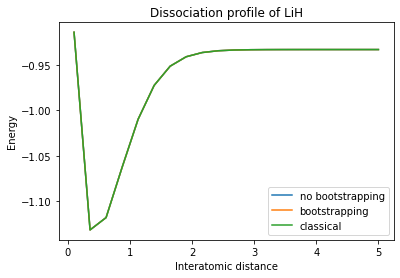

In [6]:
fig = plt.figure()
for condition,result in results.items():
    plt.plot(result['point'], result['energy'], label = condition)
plt.legend()
plt.title('Dissociation profile of LiH')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

# Compare number of evaluations

In [7]:
for condition, result_full in results_full.items():
    print('Total evaluations for ' + condition + ':')
    sum = 0
    for key in result_full:
        sum += result_full[key]['raw_result']['cost_function_evals']
    print(sum)

Total evaluations for no bootstrapping:
588
Total evaluations for bootstrapping:
520


# Extrapolation 

Here, an extrapolator added that will try to fit each (param,point) set to some specified function and suggest an initial parameter set for the next point (degree of freedom). 

- Extrapolator is based on an external extrapolator that sets the 'window', that is, the number of previous points to use for extrapolation, while the internal extrapolator proceeds with the actual extrapolation.
- In practice, the user sets the window by specifies an integer value to num_bootstrap - which also the number of previous points to use for bootstrapping. Additionally, the external extrapolator defines the space within how to extrapolate - here PCA, clustering and the standard window approach. 

In practice, if no extrapolator is defined and bootstrapping is True, then all previous points will be bootstrapped. If an extrapolator list is defined and no points are specified for bootstrapping, then the extrapolation will be done based on all previous points.

1. Window Extrapolator: An extrapolator which wraps another extrapolator, limiting the internal extrapolator's ground truth parameter set to a fixed window size
2. PCA Extrapolator: A wrapper extrapolator which reduces the points' dimensionality with PCA, performs extrapolation in the transformed pca space, and untransforms the results before returning.
3. Sieve Extrapolator: A wrapper extrapolator which performs an extrapolation, then clusters the extrapolated parameter values into two large and small clusters, and sets the small clusters' parameters to zero.
4. Polynomial Extrapolator: An extrapolator based on fitting each parameter to a polynomial function of a user-specified degree.
5. Differential Extrapolator: An extrapolator based on treating each param set as a point in space, and performing regression to predict the param set for the next point. A user-specified degree also adds derivatives to the values in the point vectors which serve as features in the training data for the linear regression.

## Here we test different two different extrapolation techniques

In [8]:
# define different extrapolators
degree = 1
extrap_poly = Extrapolator.factory("window",extrapolator=PolynomialExtrapolator(degree=degree))
extrap_diff = Extrapolator.factory("window",extrapolator=DifferentialExtrapolator(degree=degree))
extrapolators = {'poly': extrap_poly, 'diff': extrap_diff}
for key in extrapolators:
    extrap = extrapolators[key]
    # define extrapolator
    # BOPES sampler
    bs_extr = BOPESSampler(
        gsc=me_gsc,
        driver=driver
        ,bootstrap='True'
        ,num_bootstrap=None
        ,extrapolator=extrap)
    # execute
    result_extr_full, result_extr = bs_extr.compute_surface(points)
    results_full.update({key:result_extr_full})
    results.update({key:result_extr})


## Plot results

Text(0, 0.5, 'Energy')

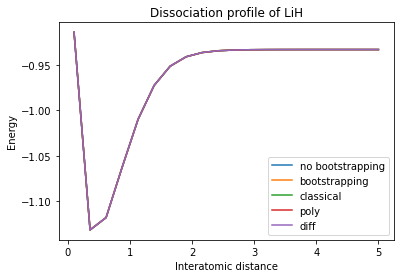

In [9]:
fig = plt.figure()
for condition,result in results.items():
    plt.plot(result['point'], result['energy'], label = condition)
plt.legend()
plt.title('Dissociation profile of LiH')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

# Compare number of evaluations

In [10]:
for condition, result_full in results_full.items():
    print('Total evaluations for ' + condition + ':')
    sum = 0
    for key in result_full:
        sum += result_full[key]['raw_result']['cost_function_evals']
    print(sum)

Total evaluations for no bootstrapping:
588
Total evaluations for bootstrapping:
520
Total evaluations for poly:
494
Total evaluations for diff:
589


In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright